### We'll analyze each boat movements for the historical ship data and work on the following KPIs:
1. Daily distance travelled
2. Daily in transit/stationary durations of boats
3. Average speed when the boat is moving

#### We'll also implement a timeseries model to forecast the next days' distance travelled 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# sample dataset size
num_samples = 4000

# Generate data for AIS boat analysis, including the column identifier (boat ID), lat/lon (location), timereceived (timestamp), course, heading, and speed_kn (knots)
sample_data = {
    "identifier": np.random.randint(1, 6, num_samples),  # 5 unique boats
    "lat": np.random.uniform(24.5, 30.0, num_samples),   # Latitude range
    "lon": np.random.uniform(-98.0, -88.0, num_samples), # Longitude range
    "timereceived": pd.date_range(start="2023-07-01", periods=num_samples, freq="15min"),  # Time intervals
    "course": np.random.uniform(0, 360, num_samples),    # Course angle (0-360)
    "heading": np.random.randint(0, 360, num_samples),   # Heading direction
    "speed_kn": np.random.uniform(0, 12, num_samples)    # Speed in knots (0-12)
}

# Create DataFrame
sample_df = pd.DataFrame(sample_data)



In [6]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   identifier    4000 non-null   int32         
 1   lat           4000 non-null   float64       
 2   lon           4000 non-null   float64       
 3   timereceived  4000 non-null   datetime64[ns]
 4   course        4000 non-null   float64       
 5   heading       4000 non-null   int32         
 6   speed_kn      4000 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int32(2)
memory usage: 187.6 KB


In [9]:
# Summary statistics
summary_stats = sample_df.describe()

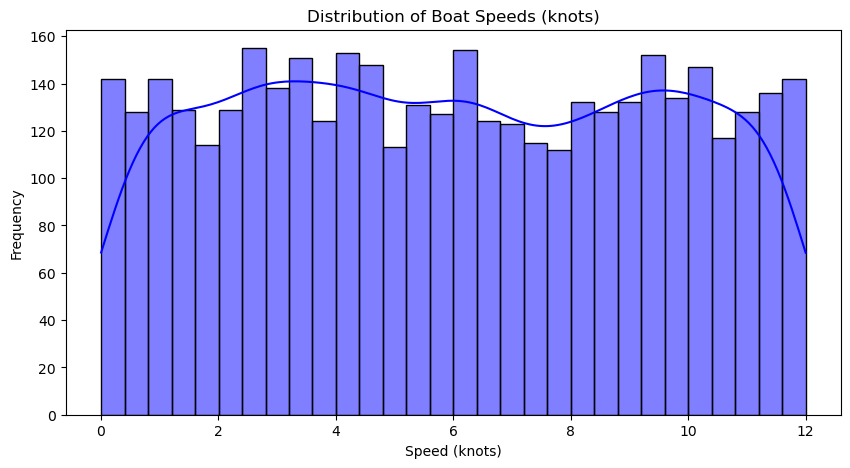

In [11]:

# Distribution of speed_kn (boat speed)
plt.figure(figsize=(10, 5))
sns.histplot(sample_df["speed_kn"], bins=30, kde=True, color="blue")
plt.title("Distribution of Boat Speeds (knots)")
plt.xlabel("Speed (knots)")
plt.ylabel("Frequency")
plt.show()


C:\Users\roushan\AppData\Local\Temp\ipykernel_25392\1877444859.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sample_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)


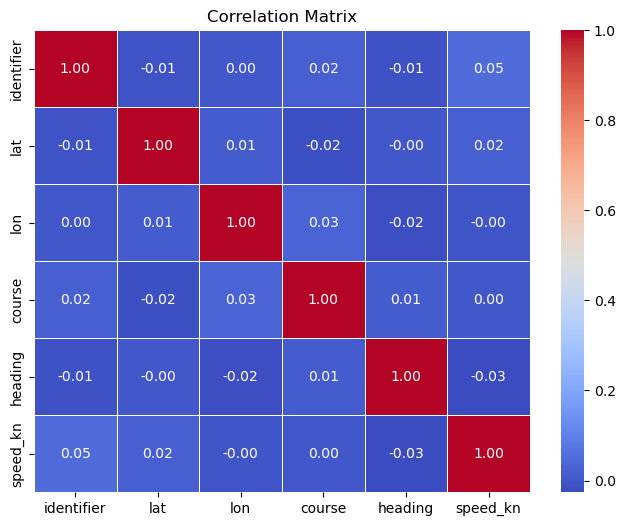

In [14]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(sample_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



We know that Low correlation values i.e. close to 0, indicate weak relationships between features. This plot shows that, lan and lon are uncorrelated in this sample dataset, which looks like a diverse boat movement patterns. And, speed has almost no correlation with course, heading and location; i.e. baot may travel at similar speeds regardless of direction.

In [17]:
# Check for duplicates
duplicate_count = sample_df.duplicated().sum()
duplicate_count


0

In [18]:
summary_stats

,identifier,lat,lon,course,heading,speed_kn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,2.957750,27.257435,-92.978873,179.252036,180.166500,5.973234
std,1.422663,1.601335,2.908168,104.639675,103.612027,3.483427
min,1.000000,24.500100,-97.998498,0.012236,0.000000,0.002137
25%,2.000000,25.833288,-95.519904,89.525970,93.000000,2.978401
50%,3.000000,27.273343,-92.958099,178.529426,181.000000,5.903006
75%,4.000000,28.691625,-90.443631,271.442020,269.000000,9.058083
max,5.000000,29.999101,-88.000536,359.981498,359.000000,11.999007


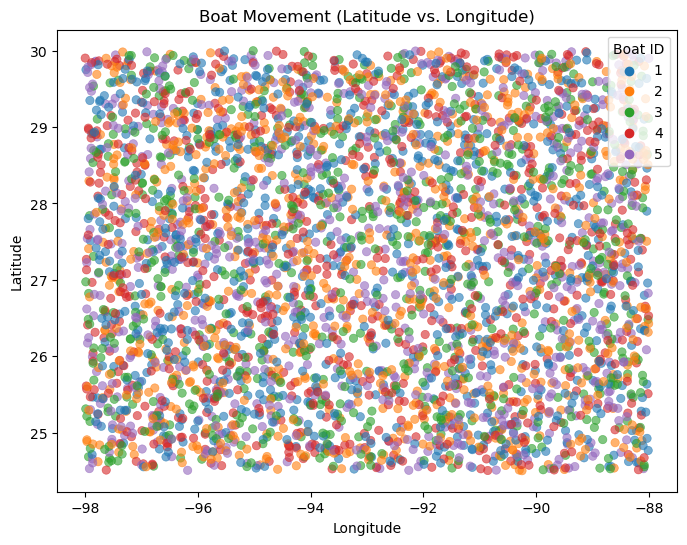

In [19]:
#Boat Movement (Lat vs. Lon) – Scatter plot of locations
plt.figure(figsize=(8, 6))
sns.scatterplot(x=sample_df["lon"], y=sample_df["lat"], hue=sample_df["identifier"], palette="tab10", alpha=0.6, edgecolor=None)
plt.title("Boat Movement (Latitude vs. Longitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Boat ID", loc="upper right")
plt.show()

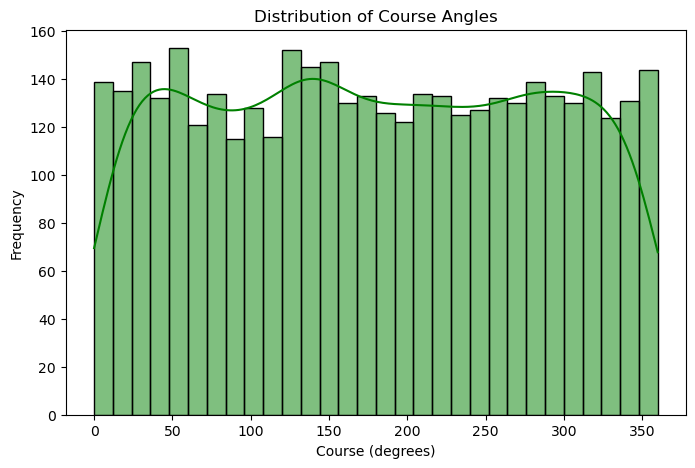

In [20]:
#Course & Heading Distribution – Circular (polar) plots

plt.figure(figsize=(8, 5))
sns.histplot(sample_df["course"], bins=30, kde=True, color="green")
plt.title("Distribution of Course Angles")
plt.xlabel("Course (degrees)")
plt.ylabel("Frequency")
plt.show()

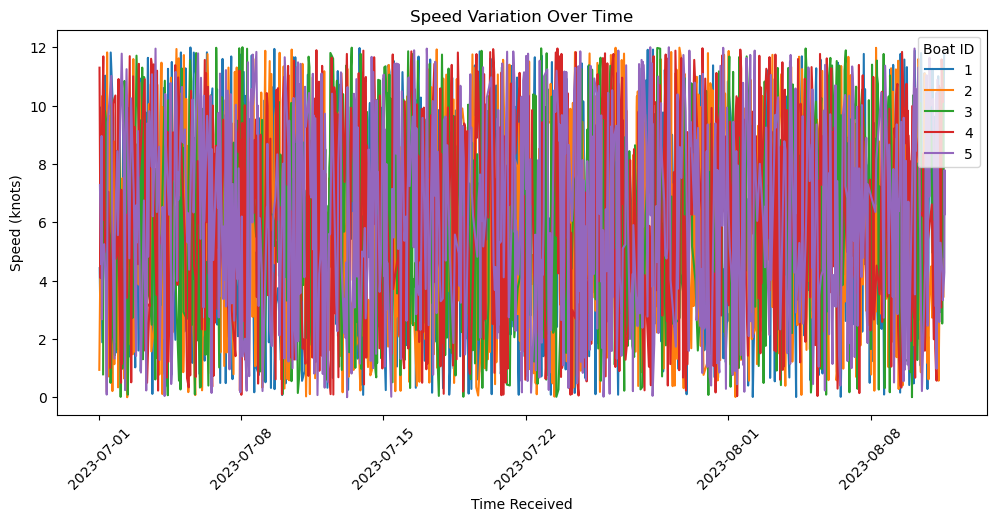

In [21]:
#Time series plot

df_sorted = sample_df.sort_values("timereceived")

plt.figure(figsize=(12, 5))
sns.lineplot(x=df_sorted["timereceived"], y=df_sorted["speed_kn"], hue=df_sorted["identifier"], palette="tab10")
plt.title("Speed Variation Over Time")
plt.xlabel("Time Received")
plt.ylabel("Speed (knots)")
plt.xticks(rotation=45)
plt.legend(title="Boat ID", loc="upper right")
plt.show()

The plot looks very dense, resampling of the data might be useful for getting clear insights, For this purpose, we can consider average speed per day.

In [50]:
# Let's Resample data to daily average speed, so that we can get the idea of daily average speed of each boat 
# we'll get a better visualization of speed

df_resampled = sample_df.groupby(["identifier", sample_df["timereceived"].dt.date])["speed_kn"].mean().reset_index(name='avg_speed_kn')
df_resampled.rename(columns={"timereceived": "date"}, inplace=True)

In [51]:
df_resampled

,identifier,date,avg_speed_kn
0,1,2023-07-01,6.350666
1,1,2023-07-02,5.812013
2,1,2023-07-03,5.193757
3,1,2023-07-04,5.545748
4,1,2023-07-05,7.012081
...,...,...,...
205,5,2023-08-07,5.993809
206,5,2023-08-08,7.377020
207,5,2023-08-09,5.039277
208,5,2023-08-10,8.336271


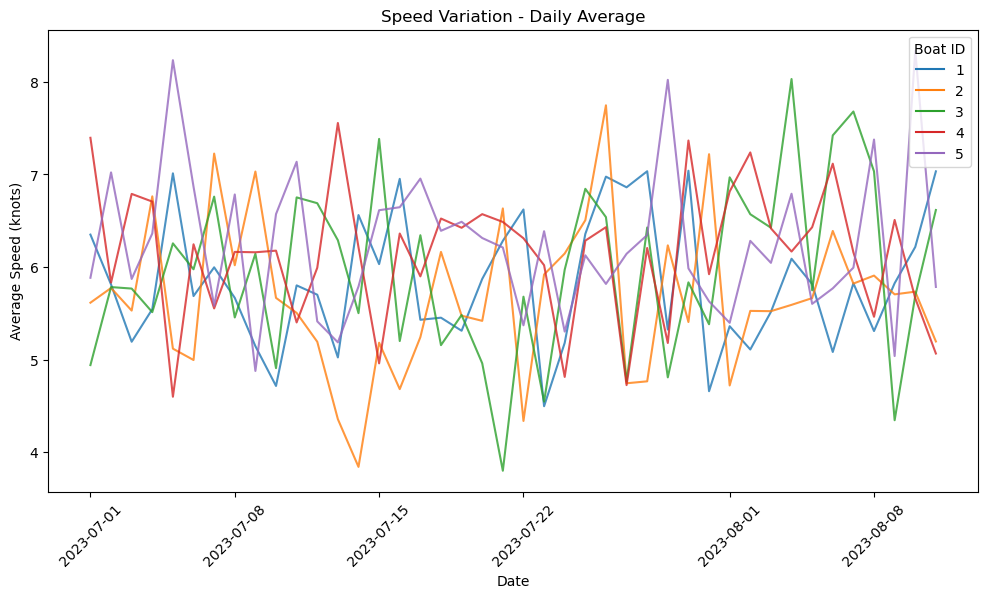

In [28]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resampled, x="date", y="speed_kn", hue="identifier", palette="tab10", alpha=0.8)
plt.title("Speed Variation - Daily Average")
plt.xlabel("Date")
plt.ylabel("Average Speed (knots)")
plt.xticks(rotation=45)
plt.legend(title="Boat ID", loc="upper right")
plt.show()

In [49]:
# Calculate 7-day moving average
#We've already computed daily average speed per boat and now we're applying a 7-day rolling average to get more smoother fluctuations.
df_resampled["speed_kn_ma_7days"] = df_resampled.groupby("identifier")["speed_kn"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df_resampled.drop('speed_kn_ma',axis=1, inplace=True)
df_resampled.head()


,identifier,date,speed_kn,speed_kn_ma_7days
0,1,2023-07-01,6.350666,6.350666
1,1,2023-07-02,5.812013,6.081340
2,1,2023-07-03,5.193757,5.785479
3,1,2023-07-04,5.545748,5.725546
4,1,2023-07-05,7.012081,5.982853


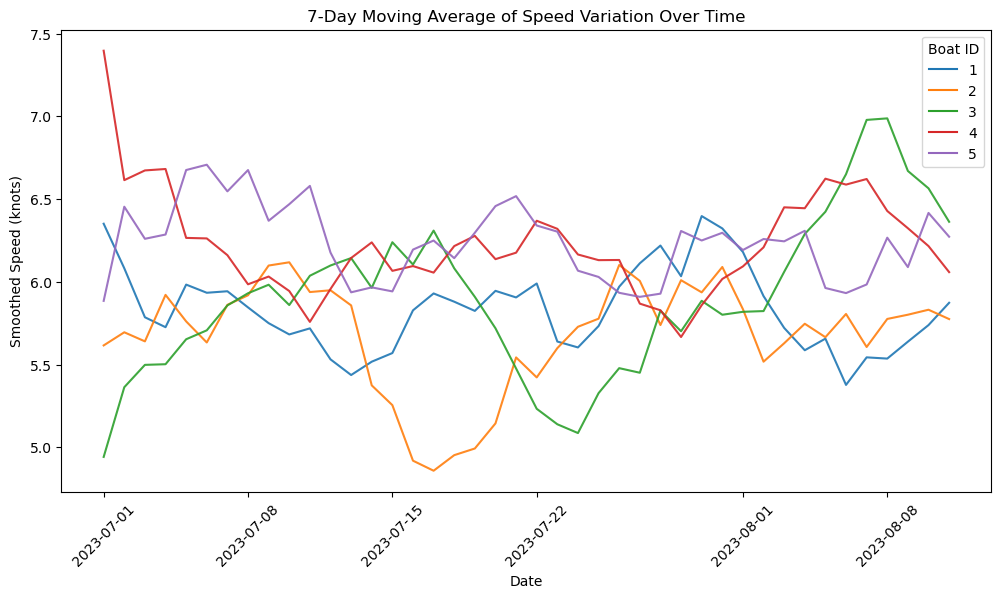

In [30]:
# Clean line chartPlot speed variation for each boat with 7-day moving average
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_resampled, x="date", y="speed_kn_ma_7days", hue="identifier", palette="tab10", alpha=0.9)
plt.title("7-Day Moving Average of Speed Variation Over Time")
plt.xlabel("Date")
plt.ylabel("Smoothed Speed (knots)")
plt.xticks(rotation=45)
plt.legend(title="Boat ID", loc="upper right")
plt.show()

In [37]:
#this function will calculate  Haversine Distance in nautical miles
from geopy.distance import geodesic

def haversine_distance (lat1, lon1, lat2, lon2):
    
    return geodesic((lat1,lon1), (lat2, lon2)).nm 

In [38]:
#Calcualting distance traveled per day
#We will use Haversine formula to compute distances between consecutive GPS points.
#then we'll aggregates distance by day.

sample_df['prev_lat'] = sample_df['lat'].shift(1)
sample_df['prev_lon'] = sample_df['lon'].shift(1)
sample_df['prev_time'] = sample_df['timereceived'].shift(1)
sample_df['distance_nm'] = sample_df.apply(
    lambda row: haversine_distance(row['prev_lat'], row['prev_lon'], row['lat'], row['lon']) 
    if pd.notna(row['prev_lat']) and pd.notna(row['prev_lon']) and pd.notna(row['lat']) and pd.notna(row['lon']) 
    else 0, 
    axis=1)
sample_df['date'] = sample_df['timereceived'].dt.date
daily_distance = sample_df.groupby('date')['distance_nm'].sum().reset_index()

In [39]:
daily_distance

,date,distance_nm
0,2023-07-01,18059.316191
1,2023-07-02,23937.306888
2,2023-07-03,20444.332740
3,2023-07-04,22078.857079
4,2023-07-05,21728.024606
5,2023-07-06,20959.354995
6,2023-07-07,20654.437424
7,2023-07-08,21466.212821
8,2023-07-09,23590.782430
9,2023-07-10,20666.463370


In [40]:
sample_df.head()

,identifier,lat,lon,timereceived,course,heading,speed_kn,prev_lat,prev_lon,prev_time,distance_nm,date
0,2,26.684129,-96.941039,2023-07-01 00:00:00,13.434549,198,0.939868,NaN,NaN,NaT,0.000000,2023-07-01
1,4,26.217571,-91.114056,2023-07-01 00:15:00,245.376312,34,11.297743,26.684129,-96.941039,2023-07-01 00:00:00,315.000823,2023-07-01
2,1,28.675550,-94.683120,2023-07-01 00:30:00,242.284469,36,4.427346,26.217571,-91.114056,2023-07-01 00:15:00,240.651486,2023-07-01
3,5,28.448167,-93.047771,2023-07-01 00:45:00,3.126616,342,7.277102,28.675550,-94.683120,2023-07-01 00:30:00,87.464778,2023-07-01
4,1,28.523087,-95.284908,2023-07-01 01:00:00,106.779013,348,3.300925,28.448167,-93.047771,2023-07-01 00:45:00,118.363220,2023-07-01


Let's set a speed threshold: 0.5 knots for calculating in-transit and stationary durations

In [41]:


sample_df['moving'] = sample_df ['speed_kn']>0.5
sample_df['time_diff'] = sample_df['timereceived'].diff().dt.total_seconds() / 3600 #time difference (in hours) between consecutive rows in the 'timereceived' column.

sample_df.head()

,identifier,lat,lon,timereceived,course,heading,speed_kn,prev_lat,prev_lon,prev_time,distance_nm,date,moving,time_diff
0,2,26.684129,-96.941039,2023-07-01 00:00:00,13.434549,198,0.939868,NaN,NaN,NaT,0.000000,2023-07-01,True,NaN
1,4,26.217571,-91.114056,2023-07-01 00:15:00,245.376312,34,11.297743,26.684129,-96.941039,2023-07-01 00:00:00,315.000823,2023-07-01,True,0.25
2,1,28.675550,-94.683120,2023-07-01 00:30:00,242.284469,36,4.427346,26.217571,-91.114056,2023-07-01 00:15:00,240.651486,2023-07-01,True,0.25
3,5,28.448167,-93.047771,2023-07-01 00:45:00,3.126616,342,7.277102,28.675550,-94.683120,2023-07-01 00:30:00,87.464778,2023-07-01,True,0.25
4,1,28.523087,-95.284908,2023-07-01 01:00:00,106.779013,348,3.300925,28.448167,-93.047771,2023-07-01 00:45:00,118.363220,2023-07-01,True,0.25


In [42]:
#daily in-transit time and stationary time
daily_transit_time = sample_df[sample_df['moving']].groupby('date')['time_diff'].sum().reset_index(name='transit_hours')
print(daily_transit_time)
daily_stationary_time = sample_df[~sample_df['moving']].groupby('date')['time_diff'].sum().reset_index(name='stationary_hours')
print(daily_stationary_time)

          date  transit_hours
0   2023-07-01          22.50
1   2023-07-02          22.50
2   2023-07-03          23.00
3   2023-07-04          22.75
4   2023-07-05          22.50
5   2023-07-06          22.50
6   2023-07-07          23.25
7   2023-07-08          23.00
8   2023-07-09          23.00
9   2023-07-10          22.25
10  2023-07-11          23.25
11  2023-07-12          22.75
12  2023-07-13          23.00
13  2023-07-14          23.50
14  2023-07-15          23.00
15  2023-07-16          23.00
16  2023-07-17          23.00
17  2023-07-18          23.00
18  2023-07-19          22.75
19  2023-07-20          22.75
20  2023-07-21          23.00
21  2023-07-22          23.00
22  2023-07-23          22.25
23  2023-07-24          22.25
24  2023-07-25          23.25
25  2023-07-26          23.25
26  2023-07-27          22.75
27  2023-07-28          23.50
28  2023-07-29          22.50
29  2023-07-30          24.00
30  2023-07-31          23.00
31  2023-08-01          22.50
32  2023-0

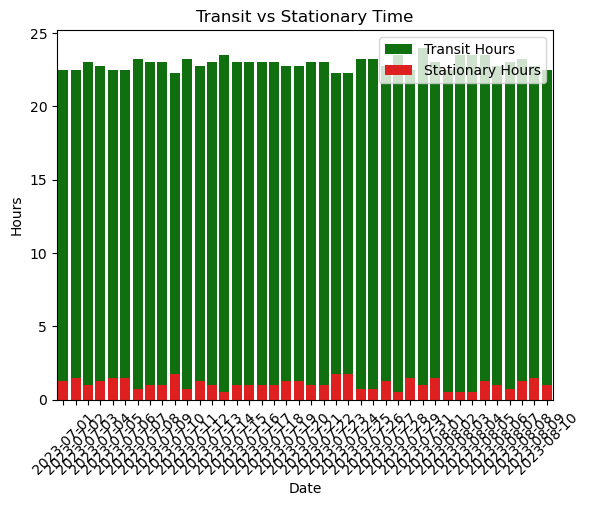

In [47]:
# Transit and Stationary Time

sns.barplot(x=daily_transit_time['date'], y=daily_transit_time['transit_hours'], color='g', label='Transit Hours')
sns.barplot(x=daily_stationary_time['date'], y=daily_stationary_time['stationary_hours'], color='r', label='Stationary Hours')
plt.title('Transit vs Stationary Time')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.legend()
plt.xticks(rotation=45)
plt.show()

We'll calculate the average boat speed when it's moving. That is we're considering a moving threshold here, which is speed_kn>0.5 knots

In [52]:
# Calculate average speed when moving
daily_avg_speed_when_moving = sample_df[sample_df['moving']].groupby('date')['speed_kn'].mean().reset_index(name='avg_speed_moving')

In [53]:
daily_avg_speed_when_moving

,date,avg_speed_moving
0,2023-07-01,6.310354
1,2023-07-02,6.364428
2,2023-07-03,6.043802
3,2023-07-04,6.453805
4,2023-07-05,6.661281
5,2023-07-06,6.377077
6,2023-07-07,6.362816
7,2023-07-08,6.307869
8,2023-07-09,6.092626
9,2023-07-10,6.010236


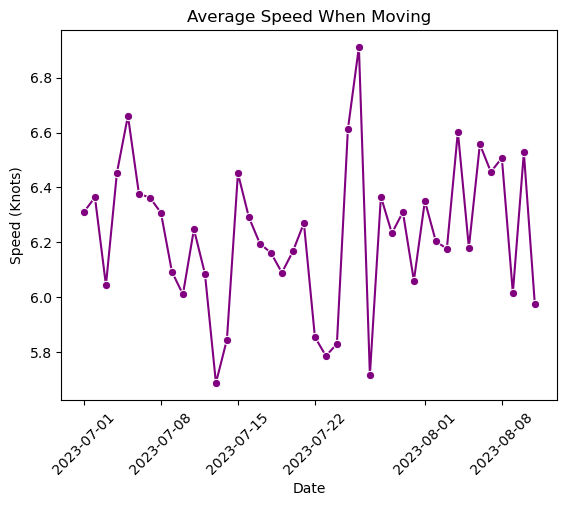

In [56]:
# visualize the plot to show the average Speed When Moving

sns.lineplot(x=daily_avg_speed_when_moving['date'], y=daily_avg_speed_when_moving['avg_speed_moving'], marker='o', color='purple')
plt.title('Average Speed When Moving')
plt.xlabel('Date')
plt.ylabel('Speed (Knots)')
plt.xticks(rotation=45)
plt.show()

Now, let's build  a forecasting model which will forecast the distance traveled in next 3 Days

In [57]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(daily_distance['distance_nm'], trend='add', seasonal=None, seasonal_periods=None).fit()
#It finds the latest date in the dataset.Then moves to the next day after the last available date, periods=3 for generating 3 future dates
future_dates = pd.date_range(start=daily_distance['date'].max() + pd.Timedelta(days=1), periods=3)

In [58]:
#Predicts the next 3 values based on the trained model.

forecast = model.forecast(3)
print(forecast)


42    21073.543215
43    20948.583517
44    20823.623818
dtype: float64


In [59]:
forecast_df = pd.DataFrame({'date': future_dates, 'predicted_distance_nm': forecast}) 

In [60]:
forecast_df

,date,predicted_distance_nm
42,2023-08-12,21073.543215
43,2023-08-13,20948.583517
44,2023-08-14,20823.623818


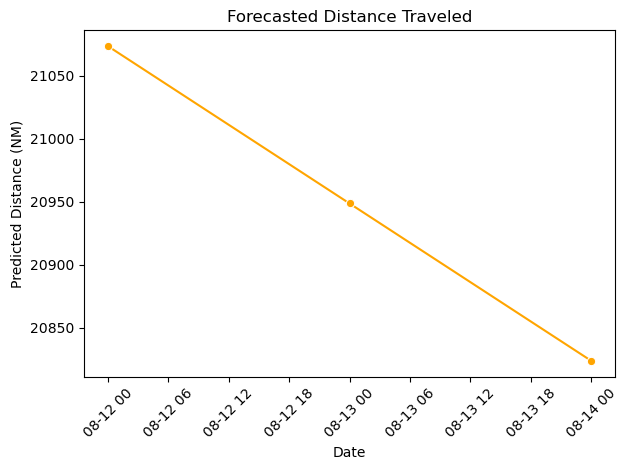

In [61]:
# Forecasted Distance Traveled

sns.lineplot(x=forecast_df['date'], y=forecast_df['predicted_distance_nm'], marker='o', color='orange')
plt.title('Forecasted Distance Traveled')
plt.xlabel('Date')
plt.ylabel('Predicted Distance (NM)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [62]:
# Displaying Results for some of the primary KPI of ship vessels datset analysis
print("Daily Distance Traveled:")
print(daily_distance)
print("\nDaily Transit Time:")
print(daily_transit_time)
print("\nDaily Stationary Time:")
print(daily_stationary_time)
print("\nAverage Speed When Moving:")
print(daily_avg_speed_when_moving)
print("\nForecasted Distance Traveled (Next 3 Days):")
print(forecast_df)

Daily Distance Traveled:
          date   distance_nm
0   2023-07-01  18059.316191
1   2023-07-02  23937.306888
2   2023-07-03  20444.332740
3   2023-07-04  22078.857079
4   2023-07-05  21728.024606
5   2023-07-06  20959.354995
6   2023-07-07  20654.437424
7   2023-07-08  21466.212821
8   2023-07-09  23590.782430
9   2023-07-10  20666.463370
10  2023-07-11  21772.953018
11  2023-07-12  24383.811081
12  2023-07-13  21582.536542
13  2023-07-14  22250.502390
14  2023-07-15  24378.270860
15  2023-07-16  23436.372548
16  2023-07-17  20400.341024
17  2023-07-18  23189.557065
18  2023-07-19  19668.410114
19  2023-07-20  25375.909179
20  2023-07-21  21589.328687
21  2023-07-22  20346.005932
22  2023-07-23  23917.895090
23  2023-07-24  21026.517074
24  2023-07-25  20832.980467
25  2023-07-26  23686.348544
26  2023-07-27  20492.922386
27  2023-07-28  24299.376146
28  2023-07-29  22966.695271
29  2023-07-30  21962.759465
30  2023-07-31  21374.638846
31  2023-08-01  21958.465870
32  2023-08-02  21